In [1]:
import findspark
findspark.init('/usr/hdp/spark/')

In [2]:
application_name = 'HLF-Classifier'
master = "yarn"
num_executors = 20
executor_memory = '6G'
driver_memory = '64G'
num_cores = 4

In [3]:
from pyspark.sql import SparkSession
import os 

os.environ["PYTHONHOME"] = "/afs/cern.ch/work/m/migliori/public/anaconda2"
os.environ["PYTHONPATH"] = "/afs/cern.ch/work/m/migliori/public/anaconda2/lib/python2.7/site-packages"

spark = SparkSession.builder\
        .appName(application_name)\
        .config("spark.pyspark.python",
                "/afs/cern.ch/work/m/migliori/public/anaconda2/bin/python")\
        .config("spark.master", master)\
        .config("spark.executor.cores", `num_cores`)\
        .config("spark.executor.instances", `num_executors`)\
        .config("spark.executor.memory", executor_memory)\
        .config("spark.driver.memory", driver_memory)\
        .config("spark.sql.execution.arrow.enabled", "true")\
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
        .config("spark.driver.maxResultSize", "64G") \
        .getOrCreate()

In [4]:
spark

## Load train and test dataframes

In [5]:
from __future__ import print_function

In [10]:
%%time
trainDF = spark.read.format('parquet') \
        .load('hdfs://p01001532067275.cern.ch/project/ML/data/trainUndersampled.parquet') \
        .select(['hfeatures_dense', 'encoded_label'])
        
testDF = spark.read.format('parquet') \
        .load('hdfs://p01001532067275.cern.ch/project/ML/data/testUndersampled.parquet') \
        .select(['hfeatures_dense', 'encoded_label'])    
        
test_events = testDF.count()
train_events = trainDF.count()
print('There are', train_events, 'training events')
print('There are', test_events, 'test events')

There are 3422692 training events
There are 855993 test events
CPU times: user 8.07 ms, sys: 4.07 ms, total: 12.1 ms
Wall time: 34.5 s


In [11]:
trainDF.printSchema()

root
 |-- hfeatures_dense: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)



## Build Keras model

In [7]:
from keras.optimizers import adam
from keras.models import Sequential
from keras.layers.core import Dense, Activation

Using TensorFlow backend.


In [8]:
model = Sequential()
model.add(Dense(50, input_shape=(14,), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                750       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 2,013
Trainable params: 2,013
Non-trainable params: 0
_________________________________________________________________


## Distributed-Keras trainer

In [9]:
from distkeras.trainers import * 
from distkeras.predictors import *
from distkeras.utils import *
from distkeras.workers import *

In [12]:
optimizer = 'adam'
loss = 'categorical_crossentropy'

num_epochs = 50 
batch_size = 200

## set the number of workers
num_workers = num_executors

In [13]:
trainer = AEASGD(keras_model=model, worker_optimizer=optimizer,
                 loss=loss, num_workers=num_workers, batch_size=batch_size,
                 features_col="hfeatures_dense", label_col="encoded_label", num_epoch=num_epochs,
                 communication_window=25, rho=5.0, learning_rate=0.1,
                 master_port=5500)
trainer.set_parallelism_factor(1)

In [15]:
%time trained_model = trainer.train(trainDF)

CPU times: user 9min 9s, sys: 9min, total: 18min 10s
Wall time: 21min 51s


In [16]:
trainer_adag = ADAG(keras_model=model, worker_optimizer=optimizer, loss=loss,
                    metrics=["accuracy"], num_workers=num_workers, batch_size=batch_size,
                    features_col="hfeatures_dense", label_col="encoded_label",
                    num_epoch=num_epochs, communication_window=2,
                    master_port=5600)
trainer_adag.set_parallelism_factor(1)

In [17]:
%time trained_model_adag = trainer_adag.train(trainDF)

CPU times: user 17min 37s, sys: 10min 44s, total: 28min 21s
Wall time: 27min 11s


## Plot worker iterations and losses

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib notebook

In [19]:
worker_id = []
worker_iterations = []
worker_trainer = []

trainers_list = [trainer, trainer_adag]
trainers_name = ['AEASGD', 'ADAG']

for t, t_name in zip(trainers_list, trainers_name):
    for i in range(t.get_num_workers()):
        worker_id.append(i)
        worker_iterations.append(len(t.get_executor_history(i)))
        worker_trainer.append(t_name)
        
trainer_dataframe = pd.DataFrame({'worker_id':worker_id,
                                  'worker_iterations':worker_iterations,
                                  'trainer':worker_trainer})
trainer_dataframe.head()

,trainer,worker_id,worker_iterations
0,AEASGD,0,49450
1,AEASGD,1,75500
2,AEASGD,2,75200
3,AEASGD,3,76150
4,AEASGD,4,79450


<IPython.core.display.Javascript object>


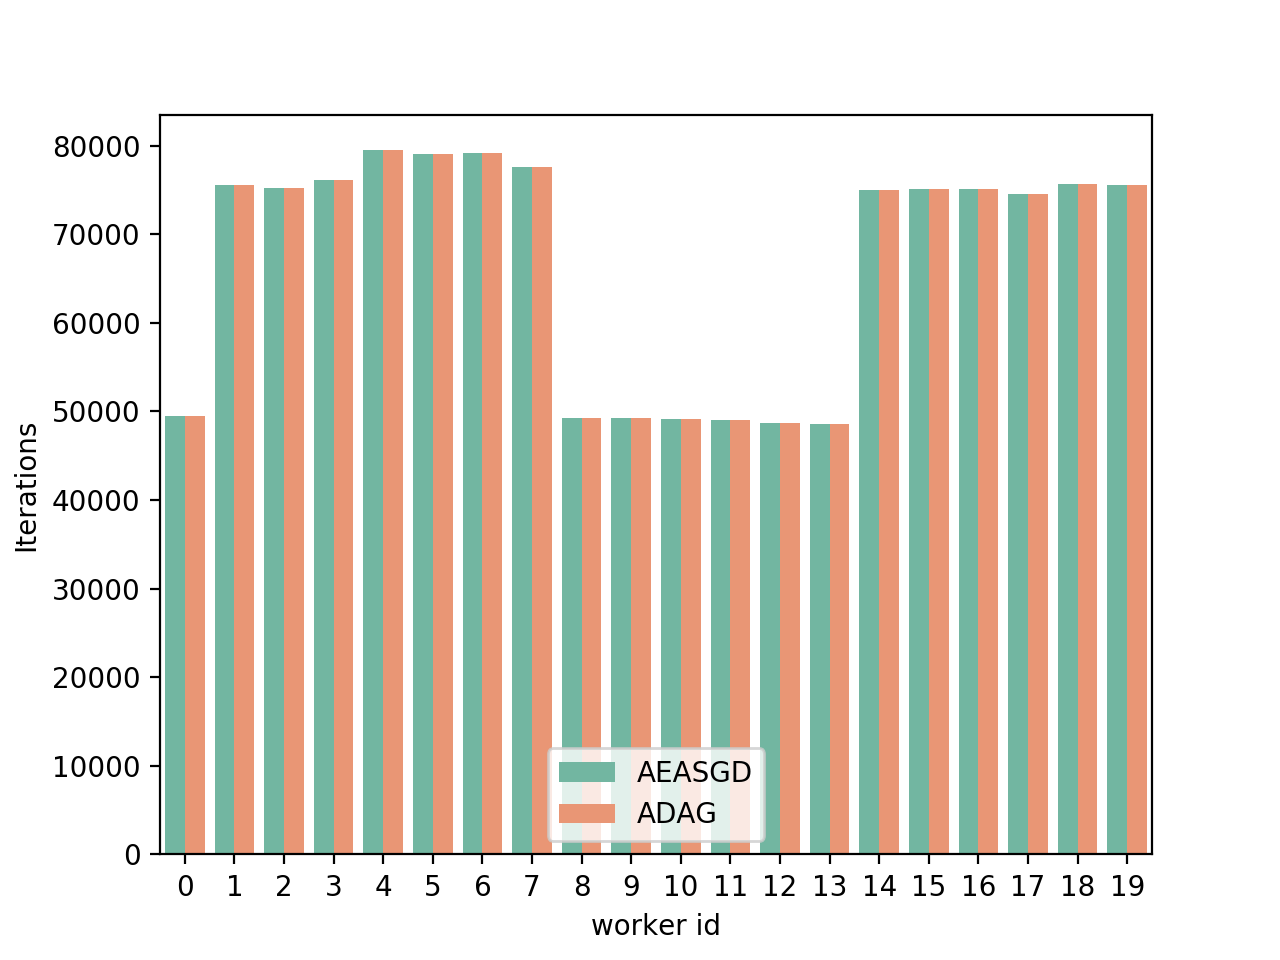

In [28]:
%matplotlib notebook 
plt.figure()
sns.barplot(x='worker_id', y='worker_iterations', hue='trainer',
              data=trainer_dataframe, palette="Set2")
plt.xlabel('worker id')
plt.ylabel('Iterations')
plt.legend(loc='lower center')
plt.show()

In [21]:
def compute_trainer_metrics(trainer):
    
    ## Get the history of each executor and find the max number of iterations
    num_workers = trainer.get_num_workers()
    max_iterations = 0
    
    history = []
    
    for i in range(num_workers):
        history.append(trainer.get_executor_history(i))
        if history[i][-1]['iteration']>max_iterations:
            max_iterations = history[i][-1]['iteration']
            
    iteration = []
    avg_loss = []
    std_loss = []

    ## Average the losses of batch_size iterations
    batch_loss = []
    batch_std = []
    
    for i in range(max_iterations):
        loss_i = [h[i]['history'][0] for h in history if i<len(h)]
        batch_loss.append(np.mean(loss_i))
        batch_std.append(np.std(loss_i))
    
        if (i%100==0) or (i==max_iterations-1):
            iteration.append(i)
            avg_loss.append(np.mean(batch_loss))
            std_loss.append(np.mean(batch_std))
            batch_loss = []
            batch_std = []
    
    iteration = np.asarray(iteration)
    loss = np.asarray(avg_loss)
    error = np.asarray(std_loss)
    
    return iteration, loss, error

In [22]:
x, y, err = compute_trainer_metrics(trainer)

In [23]:
x_adag, y_adag, err_adag = compute_trainer_metrics(trainer_adag)

<IPython.core.display.Javascript object>


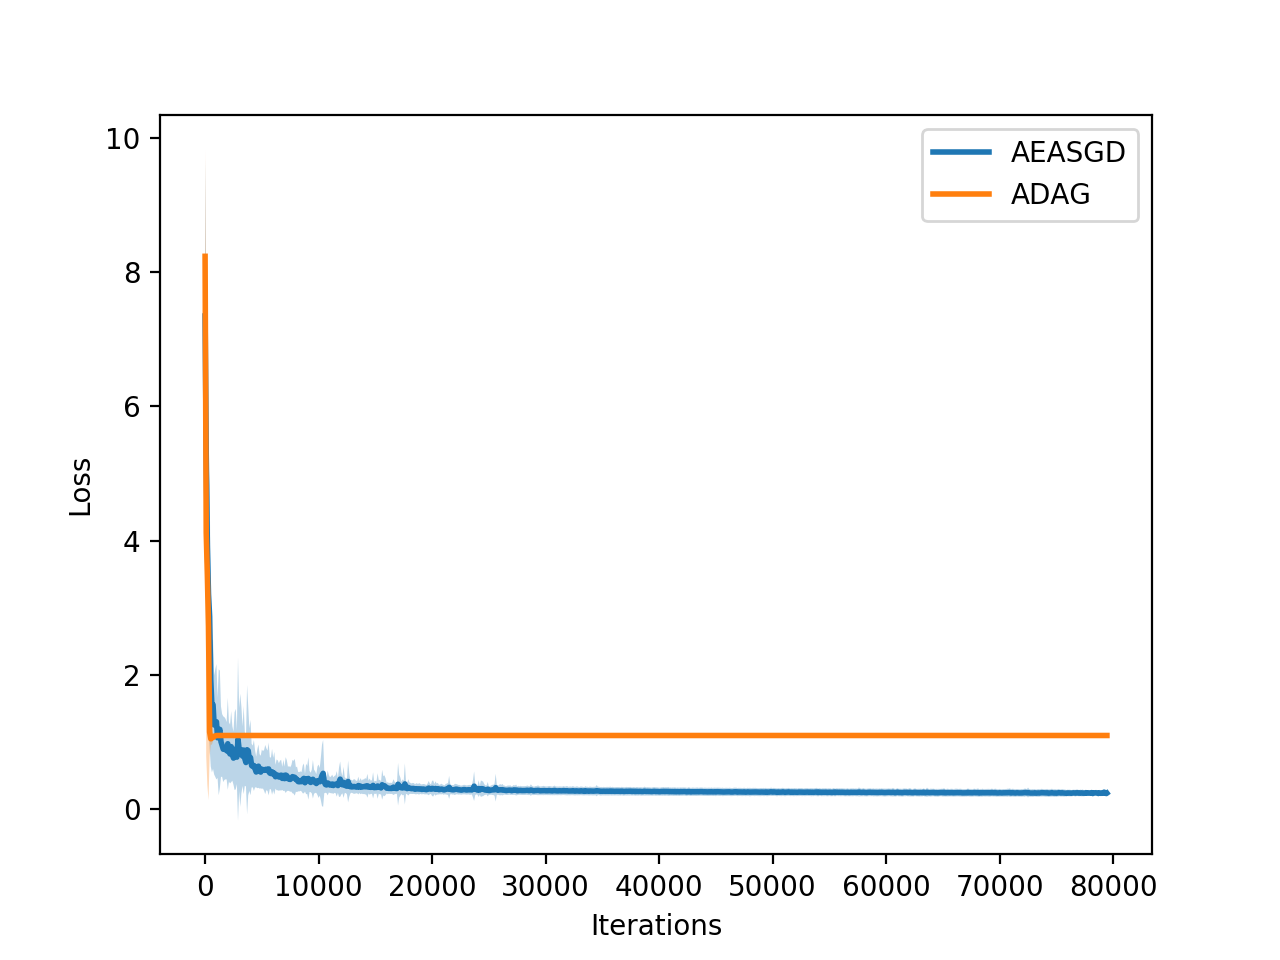

In [50]:
plt.figure()
plt.plot(x, y, lw=2, label='AEASGD')
plt.plot(x_adag, y_adag, lw=2, label='ADAG')
plt.fill_between(x, y - err , y + err, alpha=0.3)
plt.fill_between(x_adag, y_adag - err_adag,
                 y_adag + err_adag, alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save the model

In [33]:
trained_model.save('HLF_model.h5')

## Make predictions

In [36]:
predictor = ModelPredictor(keras_model=trained_model, features_col='hfeatures_dense')
pred = predictor.predict(testDF)

In [37]:
pred.select(['encoded_label', 'prediction']).show(5)

+-------------+--------------------+
|encoded_label|          prediction|
+-------------+--------------------+
|(3,[0],[1.0])|[0.66327518224716...|
|(3,[0],[1.0])|[0.90381950139999...|
|(3,[0],[1.0])|[0.76804780960083...|
|(3,[0],[1.0])|[0.83262264728546...|
|(3,[0],[1.0])|[0.84811270236968...|
+-------------+--------------------+
only showing top 5 rows



## Compute the auc

In [38]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('prediction').alias('prediction')])

In [39]:
%%time
pred_pd = pred.select(['prediction', 'encoded_label']).toPandas()

CPU times: user 585 ms, sys: 226 ms, total: 811 ms
Wall time: 37.5 s


In [40]:
pred_pd.head()

,prediction,encoded_label
0,"[0.6632751822471619, 0.004286675713956356, 0.3...","[1.0, 0.0, 0.0]"
1,"[0.9038195013999939, 0.002458845963701606, 0.0...","[1.0, 0.0, 0.0]"
2,"[0.7680478096008301, 0.004704342223703861, 0.2...","[1.0, 0.0, 0.0]"
3,"[0.8326226472854614, 0.006023559719324112, 0.1...","[1.0, 0.0, 0.0]"
4,"[0.8481127023696899, 0.004083081614226103, 0.1...","[1.0, 0.0, 0.0]"


In [42]:
import numpy as np
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['prediction'].tolist())

In [43]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


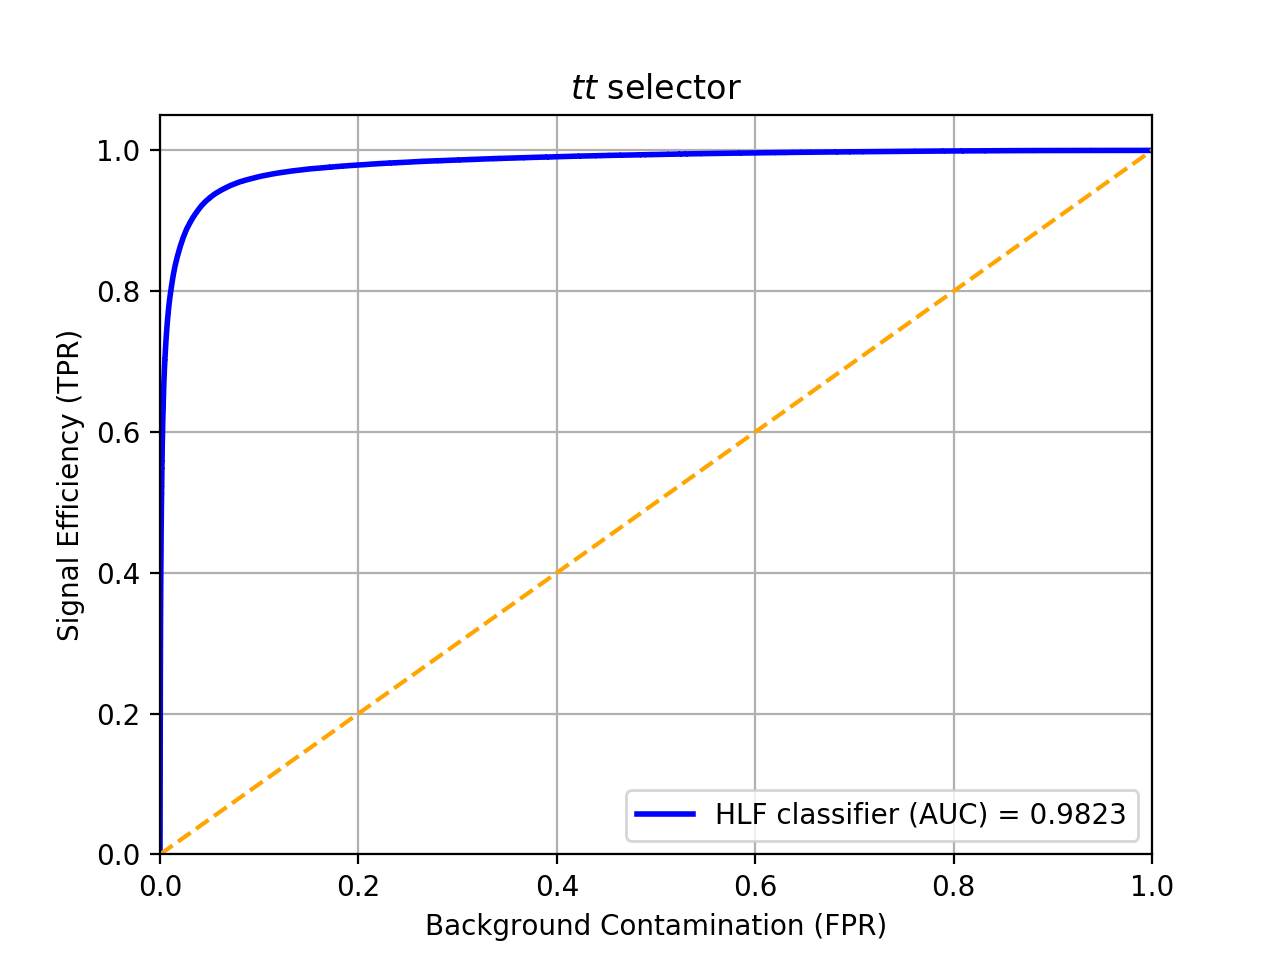

In [48]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.plot(fpr[1], tpr[1], color='blue', 
         lw=2, label='HLF classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


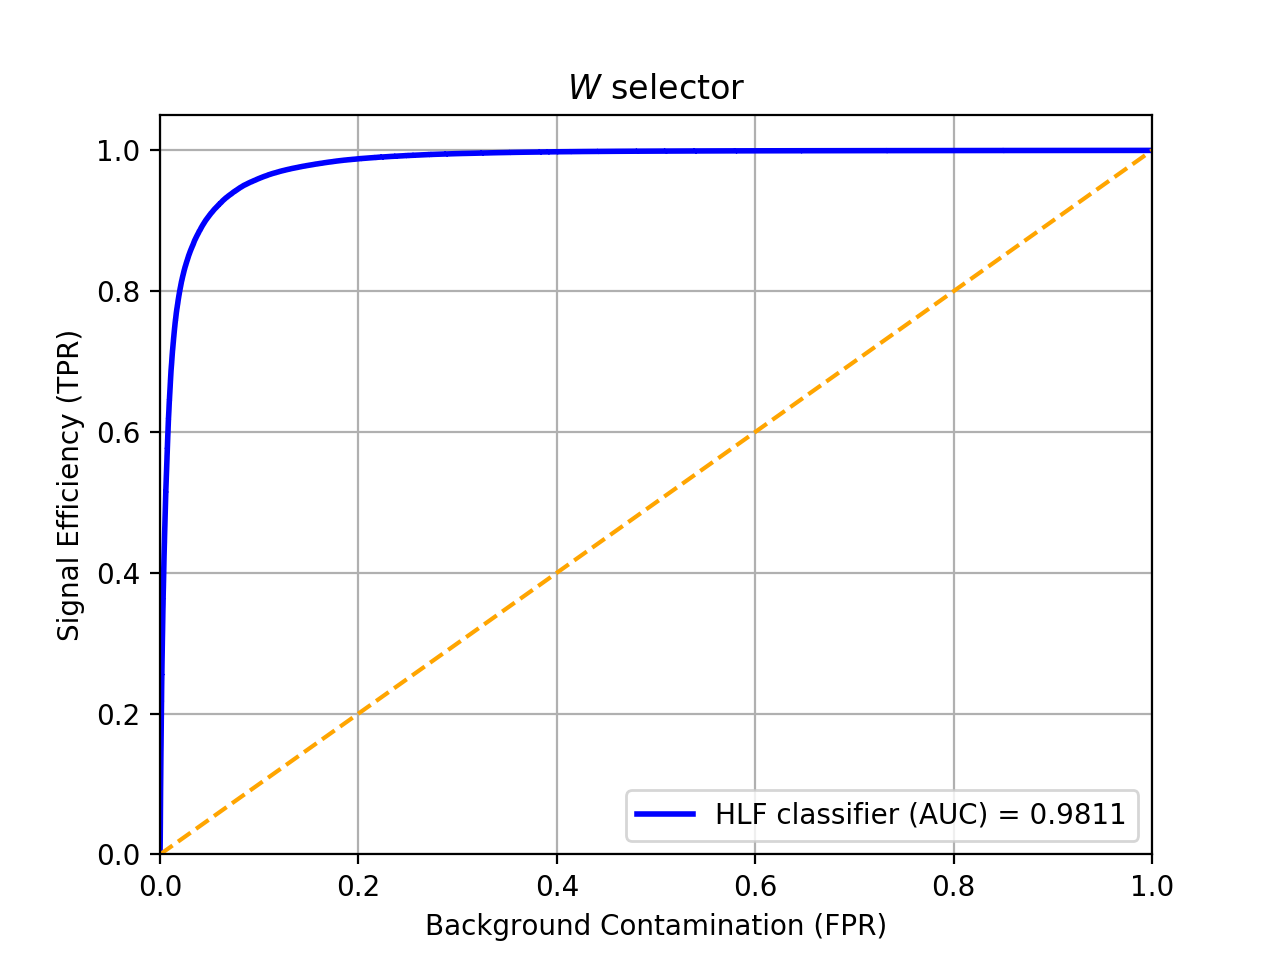

In [49]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.plot(fpr[2], tpr[2], color='blue', 
         lw=2, label='HLF classifier (AUC) = %0.4f' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()